# Implementation of Graphene in kwant

In [2]:
from math import pi, sqrt, tanh

import kwant
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../code/')

import peierls_substitution as ps

In [59]:
#  Font definitions for the plots
FONT_LABELS = 20
FONT_TITLES = 22
font = {'family' : 'serif', 'weight' : 'bold', 'size': FONT_LABELS}
mpl.rc('font', **font)
plt.rc('text', usetex=True)
mpl.rcParams["mpl_toolkits.legacy_colorbar"] = False
# plt.rc('font', family='serif')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

## Define a simple graphene strip:

In [2]:
# Define the graphene lattice
sin_30, cos_30 = (1/2, sqrt(3)/2)
graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)],
                                 [(0, 0), (0, 1 / sqrt(3))],
                                 name='Graphene')

a, b = graphene.sublattices

In [3]:
syst, leads_hand = ps.make_rect_system(W=2,L=2)

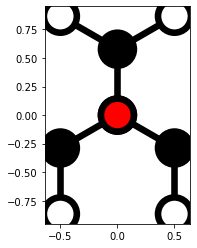

In [4]:
# Plot the closed system without leads.
lat_hydrogen = kwant.lattice.square(name='H')

syst[lat_hydrogen(0,0)] = 0
kwant.plot(syst, site_color=ps.family_colors, site_lw=0.1, colorbar=False);

In [5]:
# Attach the leads to the system.
for lead in leads_hand:
    syst.attach_lead(lead)

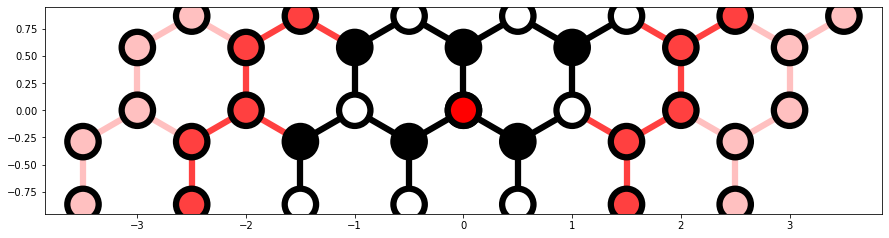

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_aspect('equal')
kwant.plot(syst, site_color=ps.family_colors, site_lw=0.1, colorbar=False, ax=ax);

### Change the hoppings: Peierls by hand

Let us include an out-of-plane magnetic field into our system. To do so, we will implement the Peierls substitution 

$$
    t_{i,j} \rightarrow t_{i,j} e^{i\phi_{ij}}
$$

where $t_{i,j}$ is the hopping amplitude **from** site-j **to** site-i ($t_{ij} \equiv t_{i\leftarrow j}$), and  the Peierls phase is defined by

$$
    \phi_{ij} = \frac{e}{\hbar} \int^{\mathbf{r}_i}_{\mathbf{r}_j} \mathbf{A}\cdot d\mathbf{l}
$$

with $\mathbf{A}$ being the vector potential, and $\mathbf{r}_i$ the position of the i-th atom. 

To get a zero magnetic field in the leads, and a magnetic field pointing in z-direction we adopt the Landau gauge given by

$$
   \mathbf{A}(\mathbf{r}) = \hat{\mathbf{y}} B \bar{x}
$$

$$
    \bar{x} = \left\{
    \begin{eqnarray}
        0, & & x < 0 \\
        x, & & 0 \leq x \leq d.\\
        d, & & x > d
    \end{eqnarray}
    \right.
$$

**IMPORTANT:** note that the vector potential can not be set to zero in the $x > d$ region, as this would imply an infinite magnetic field at the $x = d$ interface. 


**ALSO IMPORTANT:** "Since we work with a square lattice, we label the points with two integer coordinates (i, j). Builder then allows us to add matrix elements corresponding to lattice points: `syst[lat(i, j)] = ...` sets the on-site energy for the point (i, j), and `syst[lat(i1, j1), lat(i2, j2)] = ...` the hopping matrix element **from** point `(i2, j2)` **to** point `(i1, j1)`." SOURCE: [kwant documentation](https://kwant-project.org/doc/1/tutorial/first_steps).

In [9]:
## POSITION DEPENDENT HOPPINGS
def hopping_by_hand(Site1, Site2, t, B, Lm, peierls):
    return -t * peierls(Site1, Site2, B, Lm)

def peierls_1(Site1, Site2, B, Lm):
    (x_i, y_i) = Site1.pos # Target
    (x_j, y_j) = Site2.pos # Source
    x_i, x_j = change_x(x_i, Lm), change_x(x_j, Lm)
    theta = B/2 * (x_i + x_j) * (y_i - y_j)
    return np.exp(-1j*theta)

def peierls_lead_L(Site1, Site2, B, Lm):
    (x_i, y_i) = Site1.pos # Target
    (x_j, y_j) = Site2.pos # Source
    theta = -B/2 * Lm * (y_i - y_j)
    return np.exp(-1j*theta)

def peierls_lead_R(Site1, Site2, B, Lm):
    (x_i, y_i) = Site1.pos # Target
    (x_j, y_j) = Site2.pos # Source
    theta = B/2 * Lm * (y_i - y_j)
    return np.exp(-1j*theta)

def change_x(x, Lm):
    if (-Lm/2) <= x <= (Lm/2): return x
    elif x > (Lm/2): return Lm/2
    else: return -Lm/2

In [11]:
def make_graphene_peierls_by_hand(W=4.5, L=20, V=0):
    
    #### Define the scattering region. ####
    def rectangle(pos):
        x, y = pos
        return -W/2 < y < W/2 and -L/2 <= x <= L/2
    
    syst = kwant.Builder()
    syst[graphene.shape(rectangle, (0, 0))] = V

    # specify the hoppings of the graphene lattice in the
    # format expected by builder.HoppingKind
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_by_hand
    
    return syst

def make_graphene_leads_peierls_by_hand(W=4.5, V=0):
    def lead_shape(pos):
        y = pos[1]
        return -W/2 < y < W/2
    
    symmetry = kwant.TranslationalSymmetry((-1,0))
    symmetry.add_site_family(graphene.sublattices[0], other_vectors=[(-1,2)])
    symmetry.add_site_family(graphene.sublattices[1], other_vectors=[(-1,2)])
    
    lead_0 = kwant.Builder(symmetry)
    lead_0[graphene.shape(lead_shape, (0,0))] = V
    
    a, b = graphene.sublattices
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    lead_0[(kwant.builder.HoppingKind(*hopping) for hopping in hoppings)] = hopping_by_hand
    lead_1 = lead_0.reversed()
    return [lead_0, lead_1]


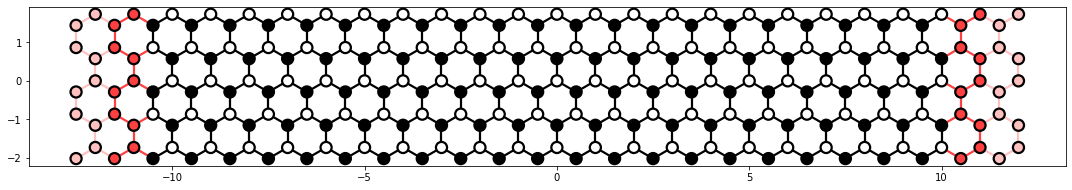

In [55]:
system_hand = make_graphene_peierls_by_hand()
lead_0_hand, lead_1_hand = make_graphene_leads_peierls_by_hand()

lead_0_hand = lead_0_hand.substituted(peierls='peierls_lead_L')
lead_1_hand = lead_1_hand.substituted(peierls='peierls_lead_R')
leads_hand = [lead_0_hand, lead_1_hand]

# Attach the leads to the system.
for lead in leads_hand:
    system_hand.attach_lead(lead)
    
fig, ax = plt.subplots(figsize=(15,3))
ax.set_aspect('equal')
kwant.plot(system_hand, site_color=ps.family_colors, site_lw=0.1, colorbar=False, ax=ax);
# plt.axis('off');
plt.tight_layout()
plt.savefig("Graphene_strip_example.png");

In [15]:
system_hand = system_hand.finalized()

In [16]:
def plot_conductance(syst, energies, params_dict, ax=None):
    # Compute transmission as a function of energy
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy, params=params_dict)
        data.append(smatrix.transmission(0, 1))
    
    if ax==None:
        fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(energies, data)
    ax.set_xlabel("energy [t]")
    ax.set_ylabel("conductance [e^2/h]")

In [31]:
parameters_hand = dict(t=1, 
                       B=0.6*np.pi,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=10,
                    )

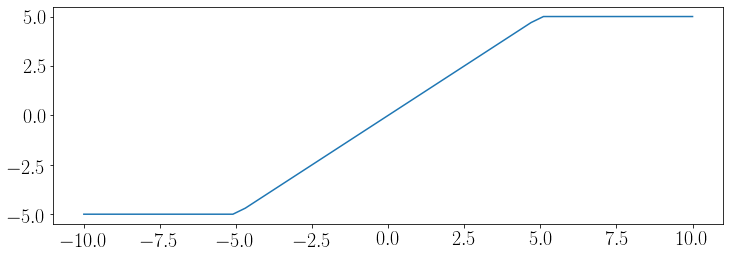

In [63]:
x_test = np.linspace(-10,10)
y_test = np.array([change_x(x,10) for x in x_test])

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x_test, y_test);

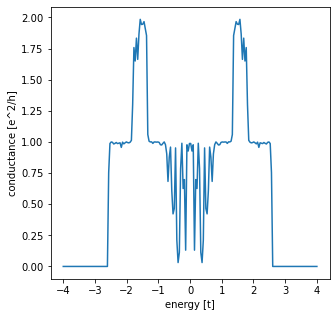

In [32]:
plot_conductance(system_hand, np.linspace(-4,4,202), parameters_hand)

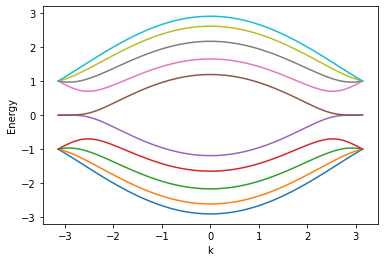

In [33]:
params_lead_0_hand = dict(t=1,
                          B=0.6,
                          peierls_lead_L=peierls_lead_L,
                          Lm=10,
                         )

lead_0_hand_finalized = lead_0_hand.finalized()
kwant.plotter.bands(lead_0_hand_finalized, params=params_lead_0_hand);

### Change the hoppings: using `kwant.physics.magnetic_gauge`

In [34]:
def make_system_peierls(hopping_func, W=4.5, L=20, pot=0):
    
    #### Define the scattering region. ####
    # circular scattering region
    def rectangle(pos):
        x, y = pos
        return -W/2 < y < W/2 and -L/2 <= x <= L/2
    
    syst = kwant.Builder()
    syst[graphene.shape(rectangle, (0, 0))] = -pot

    # specify the hoppings of the graphene lattice in the
    # format expected by builder.HoppingKind
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_func
    
    return syst

def make_leads_peierls(hopping_func, W=4.5, pot=0):
    def lead_shape(pos):
        y = pos[1]
        return -W/2 < y < W/2
    
    symmetry = kwant.TranslationalSymmetry((-1,0))
    lead_0 = kwant.Builder(symmetry)
    lead_0[graphene.shape(lead_shape, (0,0))] = -pot
    a, b = graphene.sublattices
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    lead_0[(kwant.builder.HoppingKind(*hopping) for hopping in hoppings)] = hopping_func
    lead_1 = lead_0.reversed()
    return [lead_0, lead_1]
    
def hopping_2(a, b, t, peierls):
    return -t*peierls(a, b)

In [35]:
system_gauge = make_system_peierls(hopping_2)

In [36]:
def make_lead(hopping_func, W=4.5, pot=0):
    def lead_shape(pos):
        y = pos[1]
        return -W/2 < y < W/2
    
    symmetry = kwant.TranslationalSymmetry((-1,0))
    lead0 = kwant.Builder(symmetry)
    lead0[graphene.shape(lead_shape, (0,0))] = -pot
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    lead0[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_func
    lead1 = lead0.reversed()
    return [lead0, lead1]   

In [37]:
lead_0_gauge, lead_1_gauge = make_lead(hopping_2)

In [38]:
lead_0_gauge = lead_0_gauge.substituted(peierls='peierls_lead_0')
lead_1_gauge = lead_1_gauge.substituted(peierls='peierls_lead_1')
leads_gauge = [lead_0_gauge, lead_1_gauge]

for lead in leads_gauge:
    system_gauge.attach_lead(lead)

In [39]:
system_gauge = system_gauge.finalized()
gauge = kwant.physics.magnetic_gauge(system_gauge)

In [43]:
def limited_B(pos):
    x,y = pos
    B_in = 0.1 * np.pi
    B_out = 0
    Lm = 10
    return  B_in if (-Lm/2) <= x <= (Lm/2) else B_out 

def limited_B_cont(pos):
    B_in = 0.6
    x,_ = pos
    return B_in * (1/(np.exp(-20*(x+5))+1) - 1/(np.exp(-20*(x-5))+1)) 

# peierls_syst, peierls_lead_0, peierls_lead_1 = gauge(0, 0.5, 0)
peierls_syst, peierls_lead_0, peierls_lead_1 = gauge(limited_B_cont, 0, 0)
# type(peierls_syst[0])
# len(peierls_syst)

In [50]:
y_barreira = [limited_B_cont((x,0)) for x in np.linspace(-10,10,100)]

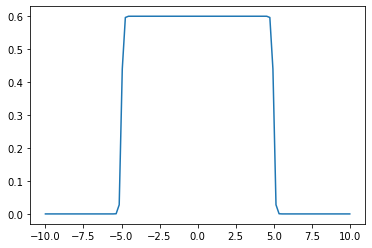

In [51]:
plt.plot(np.linspace(-10,10,100), y_barreira)

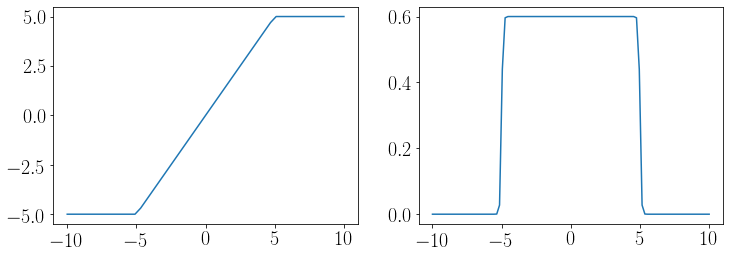

In [61]:
x_test = np.linspace(-10,10)
y_test = np.array([change_x(x,10) for x in x_test])

fig, ax = plt.subplots(ncols=2,figsize=(12,4))
ax[0].plot(x_test, y_test)
ax[0].tick_params(labelsize=20)
ax[1].plot(np.linspace(-10,10,100), y_barreira)
ax[1].tick_params(labelsize=20)

In [44]:
parameters = dict(t=1, peierls=peierls_syst,
                  peierls_lead_0=peierls_lead_0, 
                  peierls_lead_1=peierls_lead_1)

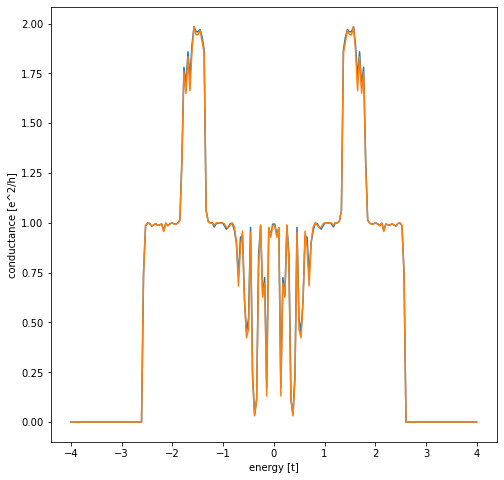

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
plot_conductance(system_gauge, np.linspace(-4,4,202), parameters, ax)
plot_conductance(system_hand, np.linspace(-4,4,202), parameters_hand, ax)

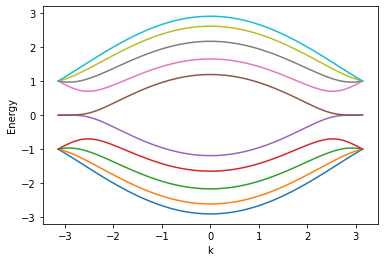

In [29]:
lead_0_gauge_final = leads_gauge[0].finalized()
kwant.plotter.bands(lead_0_gauge_final, params=dict(t=1, peierls_lead_0=peierls_lead_0));

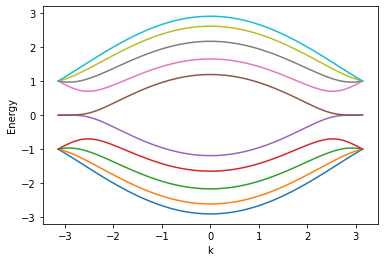

In [30]:
lead_hand = leads_hand[0].finalized()
kwant.plotter.bands(lead_hand, params=parameters_hand);

## Square lattice system

### By hand

In [ ]:
def make_whole_sqr_syst_by_hand(W, L, V=0, initialpoint=(0,0)):
    #************************************#
    #    Define the scattering region.   #
    #************************************#
    def rectangle(pos):
        x, y = pos
        return -W/2 < y < W/2 and -L/2 <= x <= L/2
    
    lat = kwant.lattice.square()
    syst = kwant.Builder()
    
    syst[lat.shape(rectangle, initialpoint)] = V # on-site term
    syst[lat.neighbors()] = hopping_func # hopping term

In [ ]:
def make_system_square_lattice(hopping_func, W=4.5, L=10, V=0, initialpoint=(0,0)):
    #************************************#
    #    Define the scattering region.   #
    #************************************#
    def rectangle(pos):
        x, y = pos
        return -W/2 < y < W/2 and -L/2 <= x <= L/2
    
    lat = kwant.lattice.square()
    syst = kwant.Builder()
    
    syst[lat.shape(rectangle, initialpoint)] = V # on-site term
    syst[lat.neighbors()] = hopping_func # hopping term
    
    return syst

def make_leads_square_lattice(hopping_func, W=4.5, V=0):
    def lead_shape(pos):
        y = pos[1]
        return -W/2 < y < W/2
    
    lat = kwant.lattice.square()
    
    # LEFT LEAD:
    symmetry_0 = kwant.TranslationalSymmetry((-1,0))
    lead_0 = kwant.Builder(symmetry_0)
    lead_0[lat.shape(lead_shape, (0,0))] = V
    lead_0[lat.neighbors()] = hopping_func
    
    # RIGHT LEAD:
    lead_1 = lead_0.reversed()
    
    return [lead_0, lead_1]

In [ ]:
syst_sqr = make_system_square_lattice(hopping_by_hand,L=3, W=3)

In [ ]:
kwant.plot(syst_sqr);

In [ ]:
leads_sqr = make_leads_square_lattice(hopping_by_hand, W=3)

lead_0_sqr_hand = leads_sqr[0].substituted(peierls='peierls_lead_L')
lead_1_sqr_hand = leads_sqr[1].substituted(peierls='peierls_lead_R')
leads_sqr_hand = [lead_0_sqr_hand, lead_1_sqr_hand]

In [ ]:
for lead in leads_sqr:
    syst_sqr.attach_lead(lead)

In [ ]:
kwant.plot(syst_sqr);

In [ ]:
parameters_sqrd = dict(t=1, 
                       B=0.15, 
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=1,
                    )

In [ ]:
plot_conductance(syst_sqr.finalized(), np.linspace(-10,10,100), parameters_sqrd)

In [ ]:
lead_sqr_L = leads_sqr[0].finalized()
kwant.plotter.bands(lead_sqr_L, params=parameters_sqrd);

In [ ]:
submatrix_sqr = syst_sqr.finalized().hamiltonian_submatrix(params=parameters_sqrd)

### Using `kwant.physics.magnetic_gauge`

In [ ]:
syst_sqr_gauge = make_system_square_lattice(hopping_2, L=3,W=3)
kwant.plot(syst_sqr_gauge);

In [ ]:
lead_sqr_gauge_0, lead_sqr_gauge_1 = make_leads_square_lattice(hopping_2, W=3)

lead_sqr_gauge_0 = lead_sqr_gauge_0.substituted(peierls='peierls_lead_0')
lead_sqr_gauge_1 = lead_sqr_gauge_1.substituted(peierls='peierls_lead_1')
leads_sqr_gauge = [lead_sqr_gauge_0, lead_sqr_gauge_1]

for lead in leads_sqr_gauge:
    syst_sqr_gauge.attach_lead(lead)
    
kwant.plot(syst_sqr_gauge);

In [ ]:


## FINALIZE THE SYSTEM
syst_sqr_gauge = syst_sqr_gauge.finalized()

## INITIATE THE GAUGE
gauge_sqr = kwant.physics.magnetic_gauge(syst_sqr_gauge)

## DEFINE THE PEIERLS PHASES
peierls_sqr_syst, peierls_sqr_lead_0, peierls_sqr_lead_1 = gauge_sqr(0.15,0,0)

## PUT THE PHASES INTO A DICTIONARY 
parameters_sqrd_gauge = dict(t=1, peierls=peierls_sqr_syst,
                  peierls_lead_0=peierls_sqr_lead_0, 
                  peierls_lead_1=peierls_sqr_lead_1)



In [ ]:
plot_conductance(syst_sqr.finalized(), np.linspace(-10,10,100), parameters_sqrd)
plot_conductance(syst_sqr_gauge, np.linspace(-10,10,100), parameters_sqrd_gauge)

In [ ]:
submatrix_sqr_gauge = syst_sqr_gauge.hamiltonian_submatrix(params=parameters_sqrd_gauge)

In [ ]:
submatrix_sqr.shape

In [ ]:
submatrix_sqr_gauge.shape

In [ ]:
submatrix_sqr[0].shape

In [ ]:
for n in submatrix_sqr[1]:
    print(n)

In [ ]:
for n in submatrix_sqr_gauge[1]:
    print(n)

### Details of the submatrix: without B

In [ ]:
syst_sqr_no_B = make_system_square_lattice(lambda s1, s2: 1, W=3, L=3, V=0, initialpoint=(0,0.5))

In [ ]:
kwant.plot(syst_sqr_no_B);

In [ ]:
submatrix_sqr_no_B = syst_sqr_no_B.finalized().hamiltonian_submatrix()

In [ ]:
def print_submatrix(submatrix):
    print('Real: ')
    for line in submatrix:
        for n in line:
            print('{:.4f}'.format(np.real(n)), end='\t')
        print()
    
    print('\nImag: ')
    for line in submatrix:
        for n in line:
            print('{:.4f}'.format(np.imag(n)), end='\t')
        print()
        

In [ ]:
print_submatrix(submatrix_sqr_no_B)

In [ ]:
sites = syst_sqr_no_B.finalized().sites

In [ ]:
sites

### Details of the submatrix: with B

In [ ]:
syst_sqr_with_B = make_system_square_lattice(hopping_by_hand, W=3, L=6, V=0)
kwant.plot(syst_sqr_with_B);


params_test_B = dict(
    peierls = peierls_1,
    Lm = 4,
    B = 1,
    t = -1
)

submatrix_sqr_with_B = syst_sqr_with_B.finalized().hamiltonian_submatrix(params=params_test_B)

In [ ]:
print_submatrix(submatrix_sqr_with_B)

### Details of submatrix: With B (using `kwant.gauge`)

In [ ]:

syst_sqr_with_B_gauge = make_system_square_lattice(hopping_2, W=3, L=3, V=0)

lead_sqr_gauge_0, lead_sqr_gauge_1 = make_leads_square_lattice(hopping_2, W=3)

lead_sqr_gauge_0 = lead_sqr_gauge_0.substituted(peierls='peierls_lead_0')
lead_sqr_gauge_1 = lead_sqr_gauge_1.substituted(peierls='peierls_lead_1')
leads_sqr_gauge = [lead_sqr_gauge_0, lead_sqr_gauge_1]

# for lead in leads_sqr_gauge:
#     syst_sqr_with_B_gauge.attach_lead(lead)

kwant.plot(syst_sqr_with_B_gauge);



## FINALIZE THE SYSTEM
syst_sqr_with_B_gauge = syst_sqr_with_B_gauge.finalized()

## INITIATE THE GAUGE
gauge_test = kwant.physics.magnetic_gauge(syst_sqr_with_B_gauge)

## DEFINE THE PEIERLS PHASES
# peierls_sqr_syst, peierls_sqr_lead0, peierls_sqr_lead1  = gauge_test(0.1,0,0)
peierls_sqr_syst  = gauge_test(0.3)

# print("Type of 'peierls_sqr_syst' = " , type(peierls_sqr_syst))

## PUT THE PHASES INTO A DICTIONARY 
params_test_B_gauge = dict(
    t = 1,                   
    peierls = peierls_sqr_syst,
#     peierls_lead_0 = peierls_sqr_lead0,
#     peierls_lead_1 = peierls_sqr_lead1,
)

submatrix_sqr_with_B_gauge = syst_sqr_with_B_gauge.hamiltonian_submatrix(params=params_test_B_gauge)

In [ ]:
print_submatrix(submatrix_sqr_with_B_gauge)

In [ ]:
submatrix_sqr_with_B_gauge[4,5]

np.arctan(submatrix_sqr_with_B_gauge[4,5].imag/submatrix_sqr_with_B_gauge[4,5].real)

## Test with 1D chain: We can't define Peierls phases in 1D

In [ ]:
def make_system_1D(hopping_func, L=10, V=0):
    
    #************************************#
    #    Define the scattering region.   #
    #************************************#
    
    def finite_wire(pos):
        x, = pos
        return -L/2 <= x <= L/2
    
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    syst[lat.shape(finite_wire, (0,))] = V # on-site term
    syst[lat.neighbors()] = hopping_func # hopping term
    
    return syst


def make_leads_1D(hopping_func, V=0):
    
    chain = kwant.lattice.chain()
    
    # LEFT LEAD:
    symmetry_0 = kwant.TranslationalSymmetry((-1,))
    lead_0 = kwant.Builder(symmetry_0)
    lead_0[chain(0,)] = V
    lead_0[chain.neighbors()] = hopping_func
    
    # RIGHT LEAD:
    symmetry_1 = kwant.TranslationalSymmetry((+1,))
    lead_1 = kwant.Builder(symmetry_1)
    lead_1[chain(0,)] = V
    lead_1[chain.neighbors()] = hopping_func

    return [lead_0, lead_1]

In [ ]:
syst_1D = make_system_1D(hopping_1, L=4)
kwant.plot(syst_1D);

In [ ]:
leads_1D = make_leads_1D(hopping_1)

lead_chain_0, lead_chain_1 = leads_1D[0], leads_1D[1]

lead_chain_0 = lead_chain_0.substituted(peierls='peierls_lead_0')
lead_chain_1 = lead_chain_1.substituted(peierls='peierls_lead_1')
leads_chain = [lead_chain_0, lead_chain_1]

for lead in leads_1D:
    syst_1D.attach_lead(lead)
    
kwant.plot(syst_1D);

## System without $\vec{B}$ and with spin

## Status: 

* System without spin
* Results adopting `kwant.physics.magnetic_gauge()` does not match the "by hand" version
* By hand version with $\vec{A} = (-yB,0,0)$ doesn't match the version with $\vec{A} = (0,xB,0)$
* Notice that in kwant's documentation they say that `Builder.substituted(param='new_param')`  produces a copy of the builder with the `new_param` instead of `param`. However, in the `gauge` example they used it wrongly, i.e., without saving the new builder and, therefore, they end up using the 'old' builder (with the old parameter).
* Proposal: try the "by hand" strategy in a square lattice.